In [13]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


### Importing the necessary libraries above and splitting the dataset in training and validation

In [14]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = "/kaggle/input/plant-disease-detection/Dataset"

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# ✅ Grab class names BEFORE applying cache/prefetch
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print("Detected classes:", class_names)

#apply performance boosts
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)

 


Found 35725 files belonging to 23 classes.
Using 28580 files for training.
Found 35725 files belonging to 23 classes.
Using 7145 files for validation.
Detected classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


## Handling the class imbalance
- Calculated class weights using compute_class_weight from sklearn.utils.
- The computed weights were passed into the model's fit() method to rebalance loss.


In [15]:
# Path to your dataset
DATASET_PATH = "/kaggle/input/plant-disease-detection/Dataset"

# Get class names and create label mapping
class_names = sorted(os.listdir(DATASET_PATH))
class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}

# Gather labels
labels = []
for class_name in class_names:
    class_folder = os.path.join(DATASET_PATH, class_name)
    image_files = os.listdir(class_folder)
    label_index = class_to_index[class_name]
    labels.extend([label_index] * len(image_files))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 0.7704882677708764, 1: 0.7817334412813725, 2: 0.8825592885375494, 3: 0.7735579421444656, 4: 0.945983159455595, 5: 0.8145277125464536, 6: 0.8141008112296053, 7: 0.8355590897396917, 8: 1.5579782826741093, 9: 1.0509501676766488, 10: 1.553304347826087, 11: 1.553304347826087, 12: 10.219107551487415, 13: 0.7302794301015924, 14: 1.553304347826087, 15: 0.8136743571640057, 16: 1.6316222141030325, 17: 0.8770775538261361, 18: 0.9267925703019612, 19: 1.1063421280812584, 20: 0.4840462286774967, 21: 4.1643548199090805, 22: 0.9763069439510289}


## Model architecture
- Used a pretrained EfficientNetB0 (from tensorflow.keras.applications) as the feature extractor.
- We added a custom classifier head:

GlobalAveragePooling2D

Dropout

Dense(23) for final softmax prediction



In [16]:
num_classes = len(train_ds_raw.class_names)

base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,418 (16.72 MB)

 Trainable params: 333,847 (1.27 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Defined our checkpoint and early stopping
- Checkpoint: Saves the best model and monitors validation accuracy
- Early stopping: Stops training early if validation loss doesn’t improve for patience number of epochs (here, it is 3).
  

In [18]:
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


## Model training

In [19]:
history = model.fit(
    train_ds_raw,
    validation_data=val_ds_raw,
    epochs=20,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 77s 60ms/step - accuracy: 0.6657 - loss: 1.1268 - val_accuracy: 0.9342 - val_loss: 0.2194
Epoch 2/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8718 - loss: 0.3912 - val_accuracy: 0.9474 - val_loss: 0.1627
Epoch 3/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.8913 - loss: 0.3299 - val_accuracy: 0.9568 - val_loss: 0.1390
Epoch 4/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.9018 - loss: 0.2963 - val_accuracy: 0.9600 - val_loss: 0.1277
Epoch 5/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.9061 - loss: 0.2708 - val_accuracy: 0.9643 - val_loss: 0.1116
Epoch 6/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.9145 - loss: 0.2506 - val_accuracy: 0.9652 - val_loss: 0.1106
Epoch 7/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.9199 - loss: 0.2368 - val_accuracy: 0.9663 - val_loss: 0.1031
Epoch 8/20
894/894 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.9226 - loss: 0.2374 - 

## Model saving
- Used two file formats

In [20]:
model.save("plant_disease_model.keras")
model.save("plant_disease_model.h5")


## Model evaluation and visualization

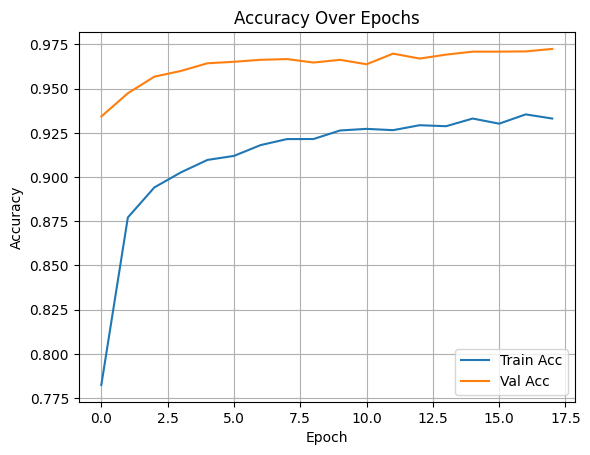

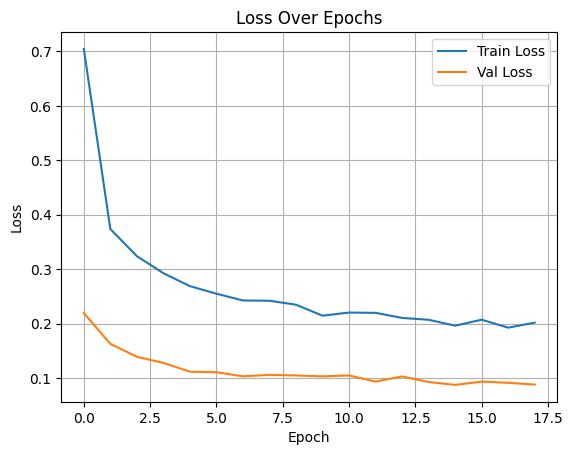

In [22]:


# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Generating predictions for the classification report

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

import os

DATASET_PATH = "/kaggle/input/plant-disease-detection/Dataset"
class_names = sorted(os.listdir(DATASET_PATH))

# Run predictions on the validation dataset
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━

### Classification report

In [25]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9950    0.9757    0.9853       412
                                 Apple___Black_rot     0.9950    1.0000    0.9975       395
                          Apple___Cedar_apple_rust     0.9947    1.0000    0.9973       372
                                   Apple___healthy     0.9801    0.9924    0.9862       397
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9479    0.9748    0.9611       317
                       Corn_(maize)___Common_rust_     1.0000    0.9974    0.9987       390
               Corn_(maize)___Northern_Leaf_Blight     0.9763    0.9561    0.9661       387
                            Corn_(maize)___healthy     1.0000    1.0000    1.0000       359
                     Pepper__bell___Bacterial_spot     0.9949    0.9510    0.9724       204
                            Pepper__bell___healthy     0.9666    0.9830    0.97

### Confusion matrix analysis

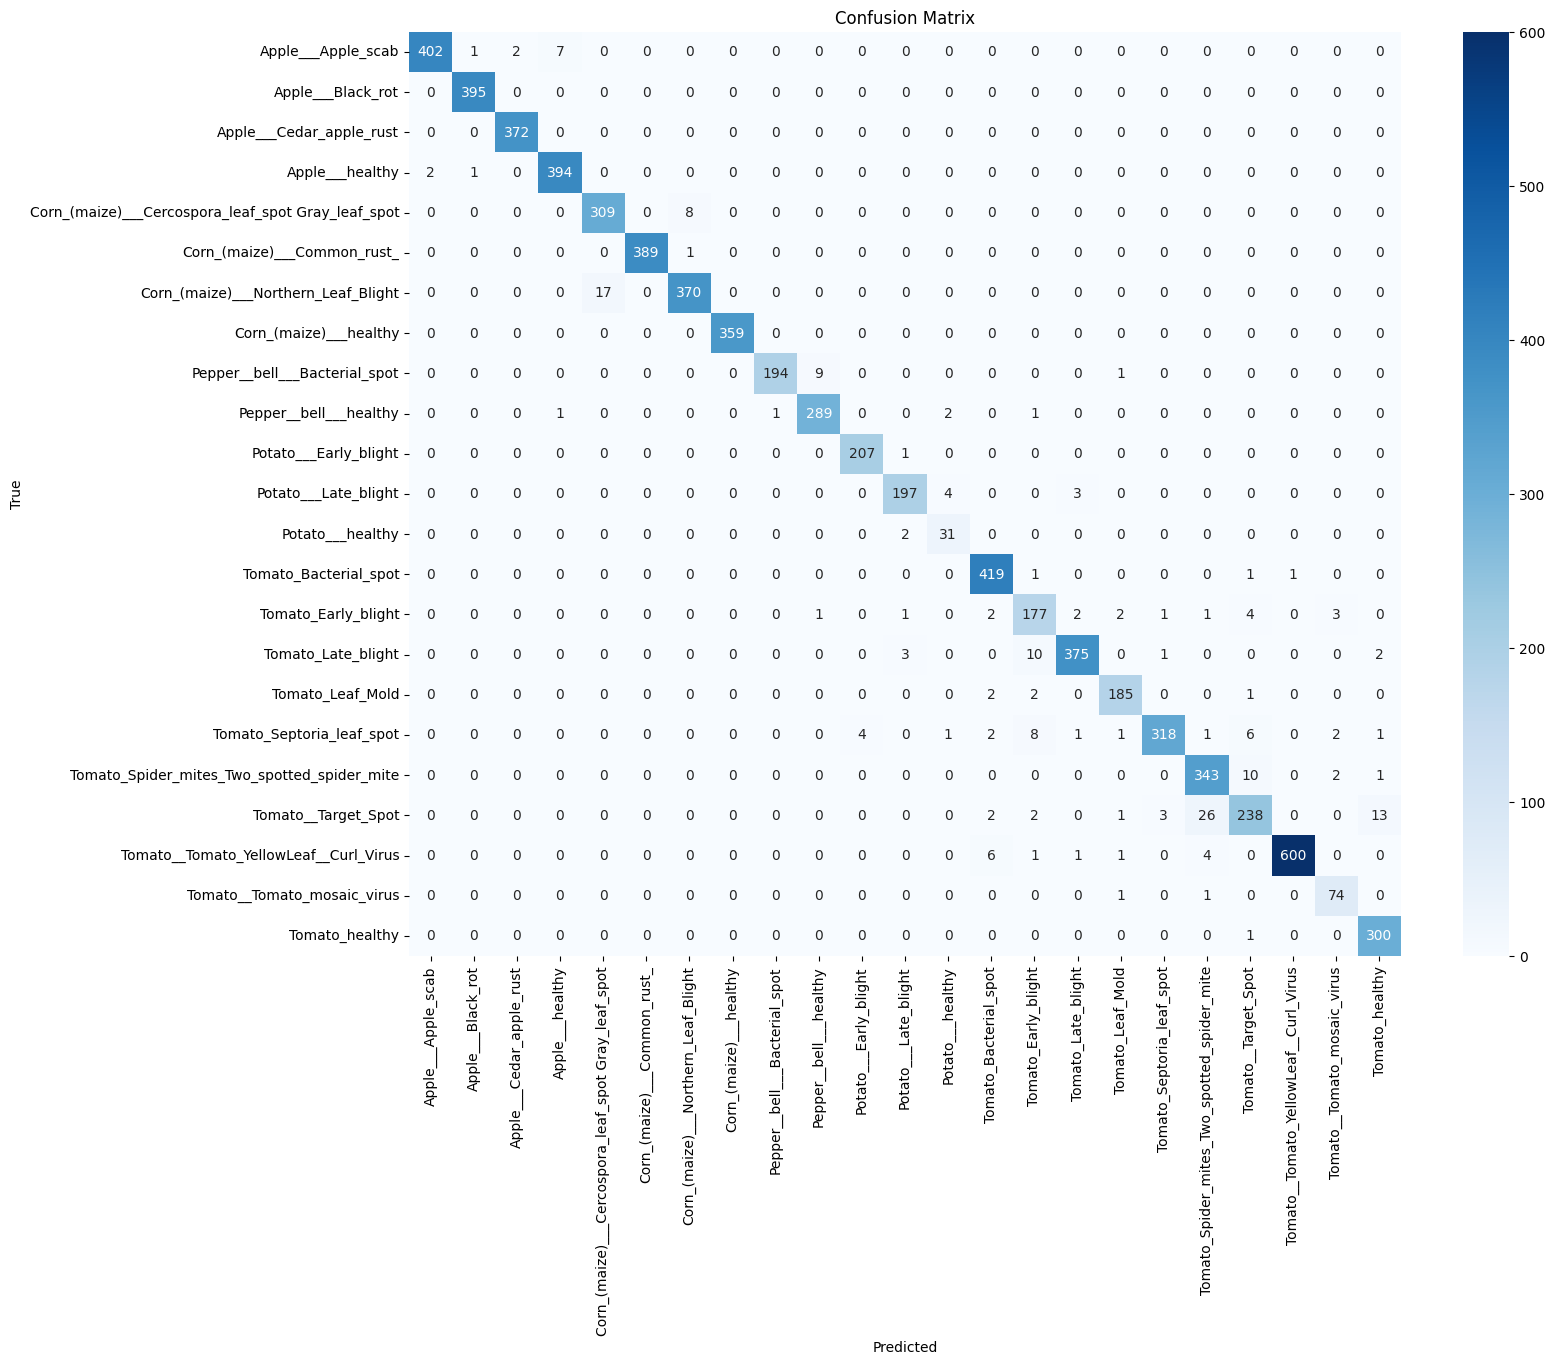

In [26]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
